UTILITIES:

sudo apt-get purge nvidia-* 


semantic dispersion through blocks. Perplexity
https://www.perplexity.ai/search/i-m-using-the-pair-cosine-simi-MX2xmvL8R2u5Z2CTC3MRqw



In [2]:
from collections import OrderedDict
import torch
import torch.nn.functional as F

import nnsight
from nnsight import NNsight

from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

from nnsight import LanguageModel

import numpy as np
from scipy.spatial.distance import cosine, euclidean

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ailab/Code/MechInt/feature-circuits/experiments')

#from embedding_analysis import BlocksEmbeddingAnalysis
from embedding_analysis import EmbeddingAnalysis

# Model inizialization

+ **wte** = word token embedding  [num_tokens, emb_dim]
    + 50257 vocab dim 
    + 768 embedding dim

+ **wpe** = word position embedding [num_tokens, emb_dim]
    + 1024 max sequence lenght
    + 768 embedding dim 

<p align="left">
    <strong>residual = wte + wpe</strong>
</p>


LLM Visualization https://bbycroft.net/llm

In [3]:
#Model Initialization
llm = LanguageModel("openai-community/gpt2", device_map="cuda")#, device_map="auto")

print(llm)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  )
)


In [4]:
num_blocks = len(llm.transformer.h)
print(f"Number of blocks in the model: {num_blocks}")


Number of blocks in the model: 12


# Inputs

In [5]:
# Input string
text = "The Eiffel Tower is in the city of"
# High variance text
high_variance_text = """The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes."""

# Low variance text
low_variance_text = """The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window."""



print(f"Number of GPT tokens in text: {len(llm.tokenizer.encode(text))}")

print(f"Number of GPT tokens in high variance text: {len(llm.tokenizer.encode(high_variance_text))}")
print(f"Number of GPT tokens in low variance text: {len(llm.tokenizer.encode(low_variance_text))}")

Number of GPT tokens in text: 10
Number of GPT tokens in high variance text: 38
Number of GPT tokens in low variance text: 25


In [6]:
llm.tokenizer.encode(text)

[464, 412, 733, 417, 8765, 318, 287, 262, 1748, 286]

# Model - nnsight

In [7]:
with llm.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.

    token_embed = llm.transformer.wte.output.save()    
    pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()
    #llm.transformer.h[-1].mlp.output[0][:] = 0
    ln_0 = llm.transformer.h[0].ln_1.output.save()
    #attn_0 = llm.transformer.h[0].attn.output.save()

    # Access the residual stream after the MLP of the 3rd GPT block
    residual_after_mlp_3 = llm.transformer.h[2].mlp.output.save()

    # Logits come out of model.lm_head and we apply argmax to get the predicted token ids.
    token_ids = llm.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)
print("type:", type(token_embed))

# Apply the tokenizer to decode the ids into words after the tracing context.
print("Prediction:", llm.tokenizer.decode(token_ids[0][-1]))
print("Residual after MLP of 3rd GPT block:", residual_after_mlp_3.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

NNsightError: No CUDA GPUs are available

In [ ]:
# André
# llm.transformer(llm.tokenizer.encode(text))

In [ ]:
with llm.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.

    token_embed = llm.transformer.wte.output.save()    
    pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()
    #llm.transformer.h[-1].mlp.output[0][:] = 0
    ln_0 = llm.transformer.h[0].ln_1.output.save()
    #attn_0 = llm.transformer.h[0].attn.output.save()

    # Logits come out of model.lm_head and we apply argmax to get the predicted token ids.
    token_ids = llm.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)
print("type:", type(token_embed))

# Apply the tokenizer to decode the ids into words after the tracing context.
print("Prediction:", llm.tokenizer.decode(token_ids[0][-1]))


Token IDs: tensor([[ 198,   12,  417, 8765,  318,  257,  262, 3504, 7372, 6342]],
       device='cuda:0')
type: <class 'torch.Tensor'>
Prediction:  Paris


In [ ]:
#Prediction for each input token
for i, id in enumerate(token_ids[0]):
    print(llm.tokenizer.decode(llm.tokenizer.encode(text)[i]), "--->",  llm.tokenizer.decode(id))

The ---> 

 E ---> -
iff ---> el
el --->  Tower
 Tower --->  is
 is --->  a
 in --->  the
 the --->  middle
 city --->  centre
 of --->  Paris


In [ ]:
ln_0.shape

torch.Size([1, 10, 768])

# Check embedding 

In [ ]:
token_embed.shape, pos_embed.shape

(torch.Size([1, 10, 768]), torch.Size([1, 10, 768]))

In [ ]:
residual_input = token_embed + pos_embed

In [ ]:
input_embed.shape, token_embed.shape, residual_input.shape, torch.equal(residual_input, input_embed)

(torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 True)

In [ ]:
input_embed.shape, input_embed[0].shape

(torch.Size([1, 10, 768]), torch.Size([10, 768]))

# Results
text --> 0.046019245  



#### Cosine Similarity
Definition: Cosine similarity measures the cosine of the angle between two vectors.  
It is calculated as:
$$ \text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \|\mathbf{b}\|} $$
if $\mathbf{a}$ and $\mathbf{b}$ are normalized vetors $\implies$ $\|\mathbf{a}\| = 1$ and $\|\mathbf{b}\| = 1$: 
$$ \text{cosine\_similarity}(\mathbf{a}, \mathbf{b}) = {\mathbf{a} \cdot \mathbf{b}} $$


+ **Normalization**: Normalizing vectors to unit length ensures that cosine similarity measures directional similarity, independent of vector magnitudes.

+ **Scale Invariance**: Cosine similarity is invariant to the magnitude of the vectors. It focuses on the orientation (**direction**) of the vectors, making it useful when the magnitude is not important.

**Cosine Similarity** summary: 
+ Measures the angle between vectors, 
+ invariant to magnitude, 
+ useful for directional data.



#### Euclidean Distance
Definition: Euclidean distance measures the straight-line distance between two points in Euclidean space.  
It is calculated as:

$$ \text{euclidean\_distance}(\mathbf{a}, \mathbf{b}) = \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2} $$

where $a_i$ and $b_i$ are the components of vectors $\mathbf{a}$ and $\mathbf{b}$.

Pros:

+ **Intuitive**: Euclidean distance is a straightforward and intuitive measure of distance between points.
+ **Sensitive to Magnitude**: It captures both the direction and magnitude of the vectors, making it useful when the absolute differences are important.
Cons:

+ **Scale Sensitivity**: Euclidean distance is sensitive to the scale of the vectors. Differences in magnitude can dominate the distance measure, which may not be desirable in some cases.
Not Invariant to Magnitude: Unlike cosine similarity, it does not normalize the vectors, so vectors with different magnitudes can have large distances even if they are in the same direction.

**Euclidean Distance** summary: 
+ Measures the straight-line distance, 
+ sensitive to magnitude, 
+ intuitive for geometric distances.


# Class EmbeddingAnalysis 

In [ ]:
analysis = EmbeddingAnalysis(llm, text)
lst_embeddings_through_blocks_text = analysis.trace_embeddings_through_blocks()
len(lst_embeddings_through_blocks_text), lst_embeddings_through_blocks_text[0].shape, lst_embeddings_through_blocks_text[1].shape, lst_embeddings_through_blocks_text[7].shape

(13,
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]),
 torch.Size([1, 10, 768]))

In [ ]:
analysis = EmbeddingAnalysis(llm, text)
mean_cosine_similarity = analysis.get_mean_cosine_similarity()
mean_cosine_similarity


0.6848686933517456

# text = "The Eiffel Tower is in the city of" 

In [ ]:
text

'The Eiffel Tower is in the city of'

Mean Cosine Similarity: 0.6848686933517456


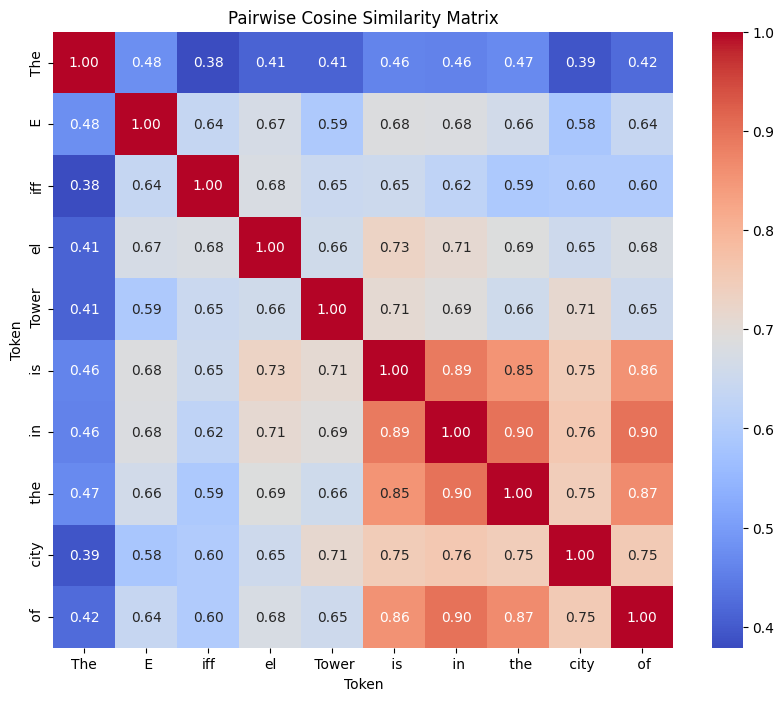

Mean Euclidean Distance: 4.586528301239014


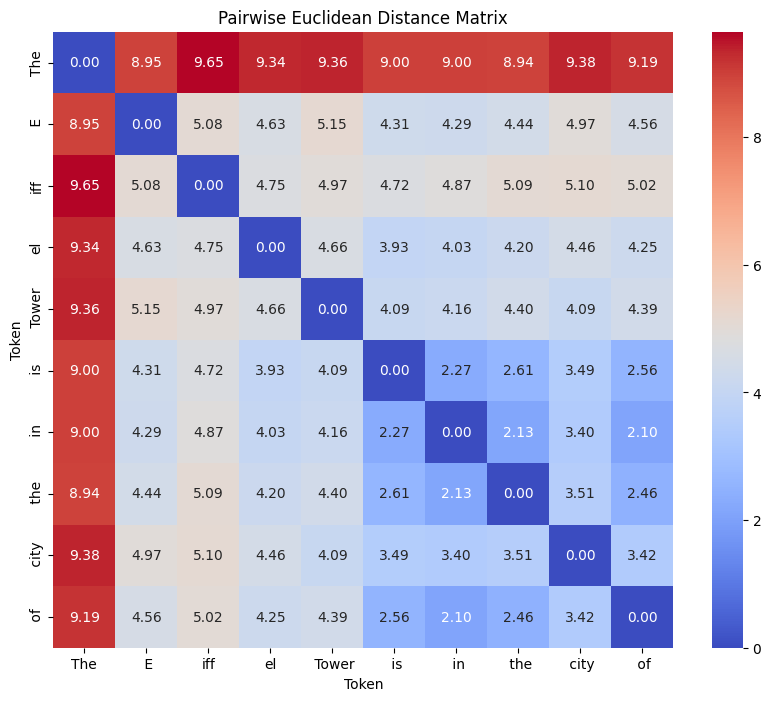

In [ ]:
# Usage
analysis = EmbeddingAnalysis(llm, text)
analysis.analyze()

In [ ]:
#check cosine similarity
cosine_sim_0_1 = F.cosine_similarity(input_embed[0][0], input_embed[0][1], dim=0)
cosine_sim_0_2 = F.cosine_similarity(input_embed[0][0], input_embed[0][2], dim=0)
cosine_sim_0_1, cosine_sim_0_2

(tensor(0.4774, device='cuda:0', grad_fn=<SumBackward1>),
 tensor(0.3789, device='cuda:0', grad_fn=<SumBackward1>))

In [ ]:
# check
euclidean_distance_0_1 = torch.norm(input_embed[0][0] - input_embed[0][1], p=2)
euclidean_distance_0_2 = torch.norm(input_embed[0][0] - input_embed[0][2], p=2)

euclidean_distance_0_1, euclidean_distance_0_2

(tensor(8.9531, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>),
 tensor(9.6535, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>))

# high_variance_text

In [ ]:
print(high_variance_text)

The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes.


Mean Cosine Similarity: 0.5807138085365295


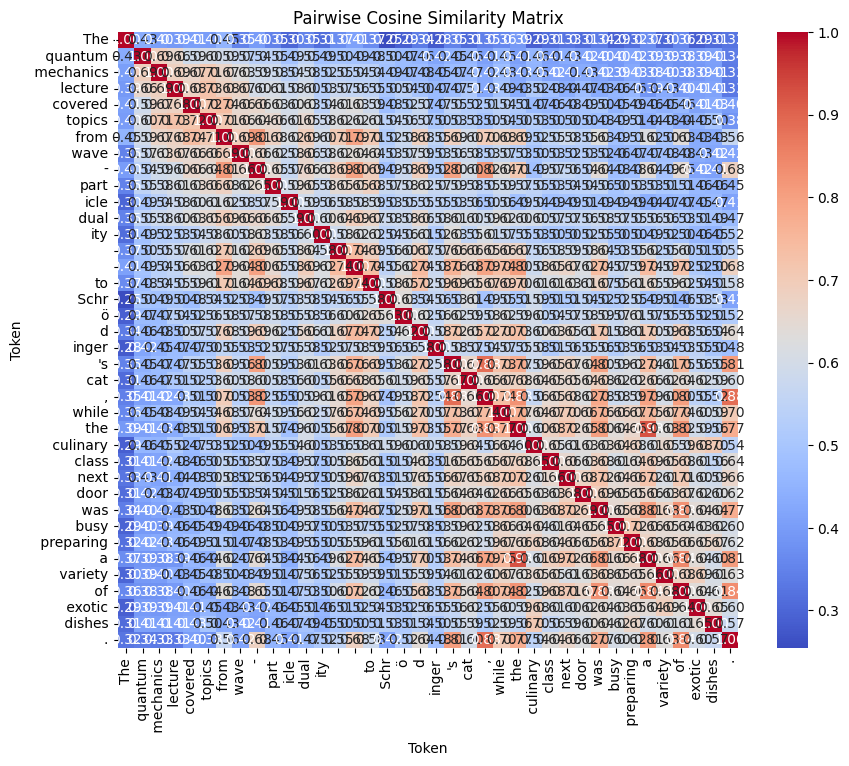

Mean Euclidean Distance: 4.793774604797363


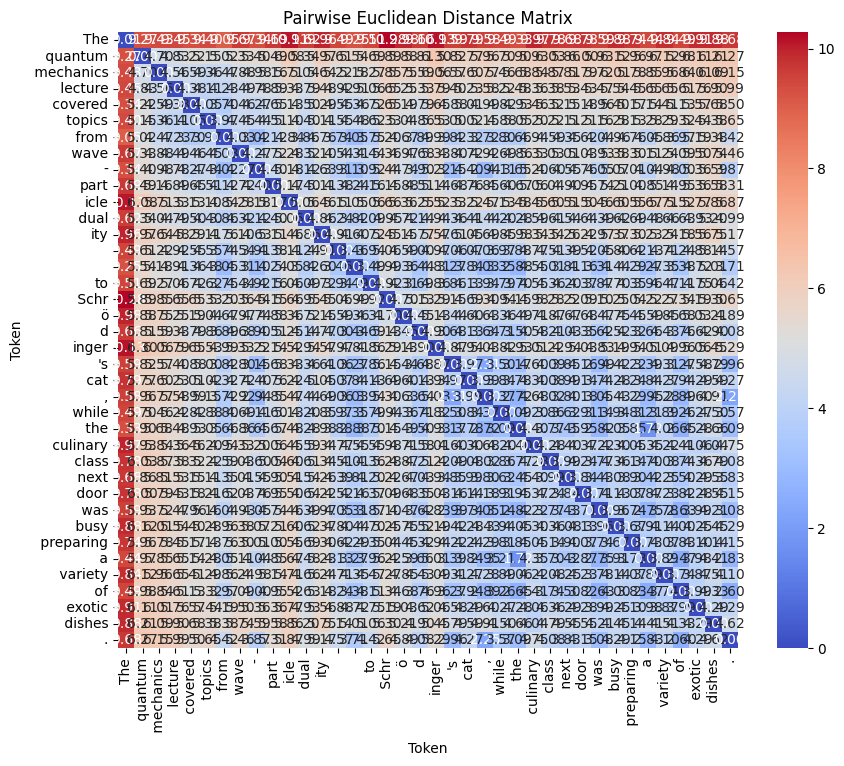

In [ ]:
analysis_high = EmbeddingAnalysis(llm, high_variance_text)
analysis_high.analyze()

# low_variance_text

In [ ]:
print(low_variance_text)

The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window.


Mean Cosine Similarity: 0.6258313059806824


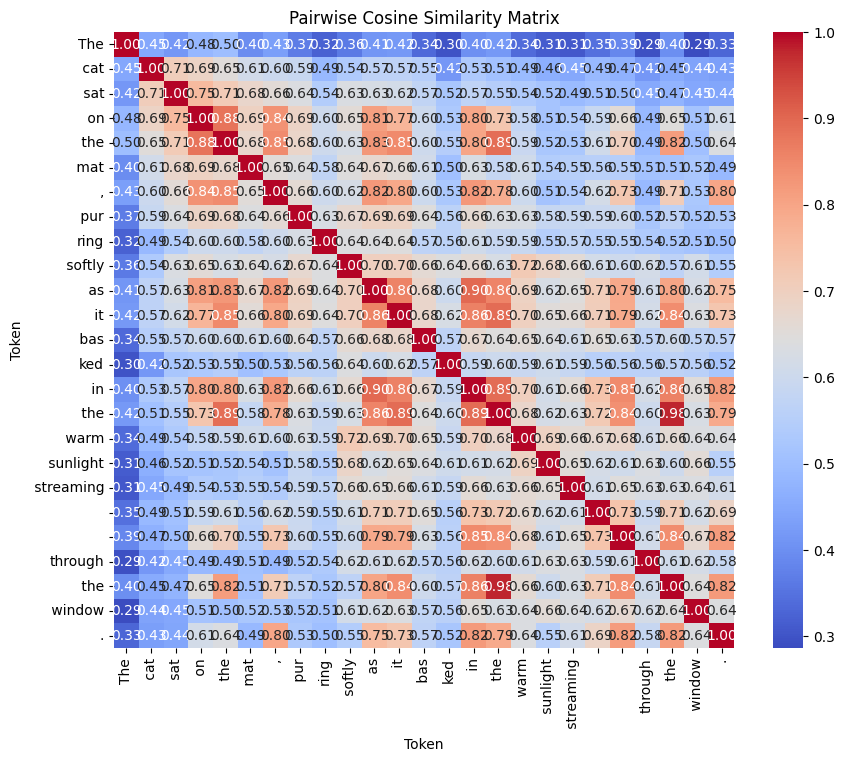

Mean Euclidean Distance: 4.582704544067383


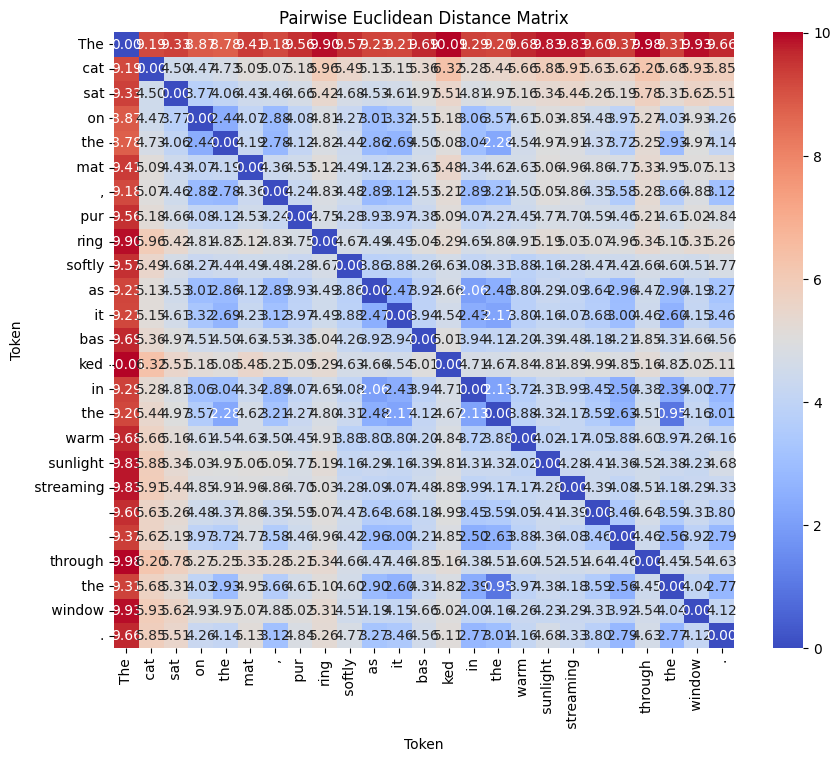

In [ ]:
analysis_low = EmbeddingAnalysis(llm, low_variance_text)
analysis_low.analyze()

[0.6258313059806824, 0.6848686933517456, 0.5807138085365295] [4.582704544067383, 4.586528301239014, 4.793774604797363]


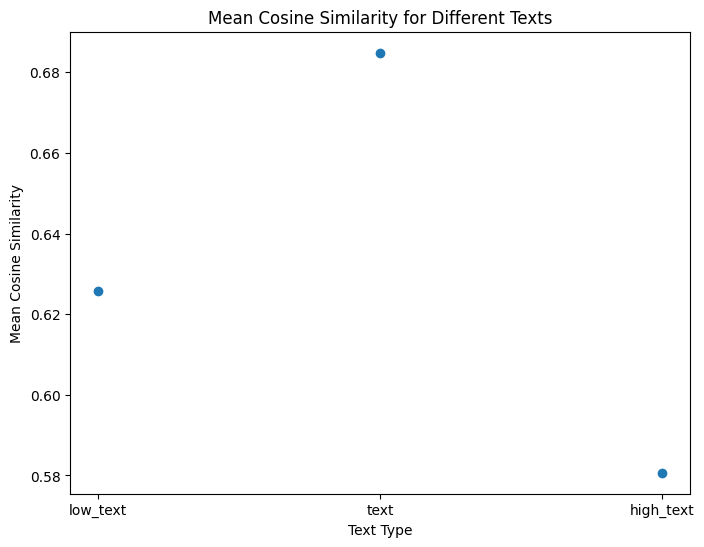

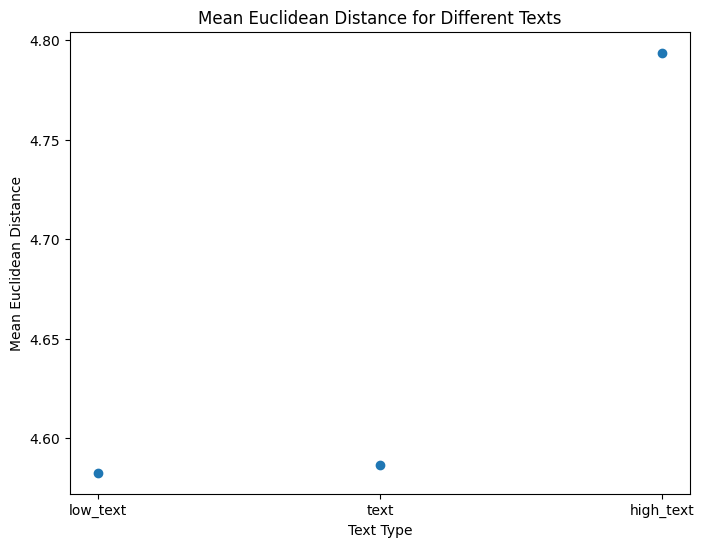

In [ ]:
#analysis_low, analysis, analysis_high 
lst_mean_cosine_similarity = [analysis_low.get_mean_cosine_similarity(), analysis.get_mean_cosine_similarity(), analysis_high.get_mean_cosine_similarity()]
lst_mean_euclidean_distance = [analysis_low.get_mean_euclidean_distance(), analysis.get_mean_euclidean_distance(), analysis_high.get_mean_euclidean_distance()]
print(lst_mean_cosine_similarity, lst_mean_euclidean_distance)

labels = ['low_text', 'text', 'high_text']
plt.figure(figsize=(8, 6))
plt.plot(labels, lst_mean_cosine_similarity, marker='o', linestyle='None')
plt.xlabel('Text Type')
plt.ylabel('Mean Cosine Similarity')
plt.title('Mean Cosine Similarity for Different Texts')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(labels, lst_mean_euclidean_distance, marker='o', linestyle='None')
plt.xlabel('Text Type')
plt.ylabel('Mean Euclidean Distance')
plt.title('Mean Euclidean Distance for Different Texts')
plt.show()

# Class BlocksEmbeddingAnalysis

In [ ]:
ana

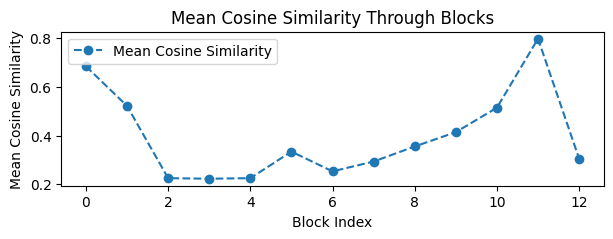

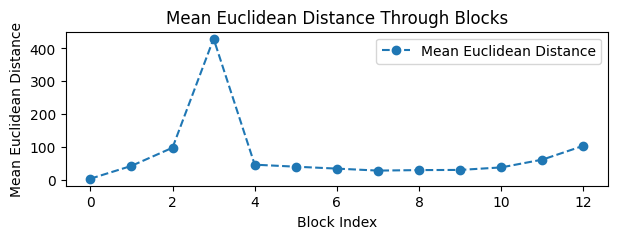

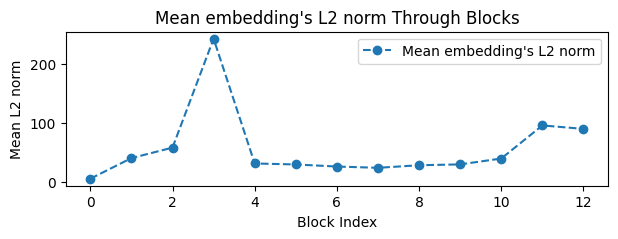

In [ ]:
EmbeddingAnalysis(llm, text).analyze_through_blocks()

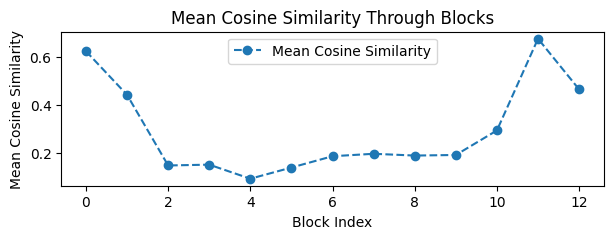

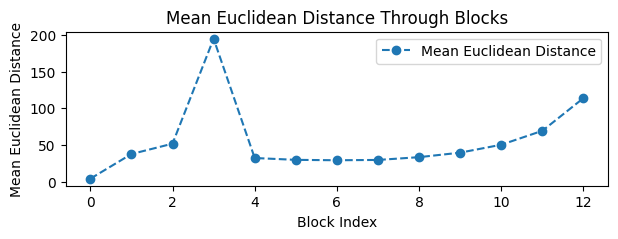

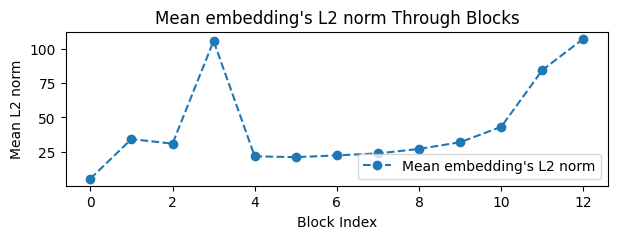

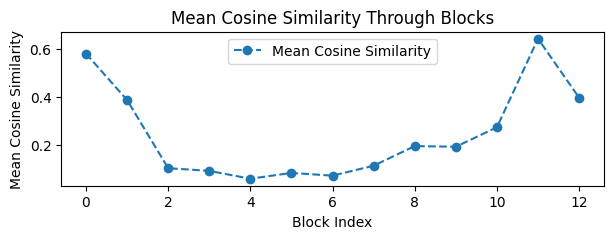

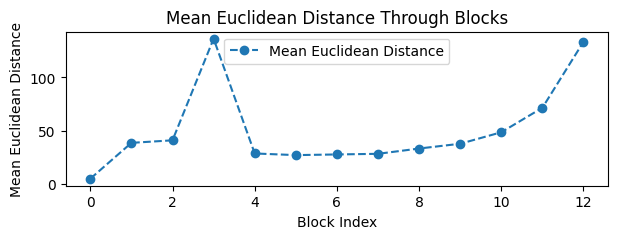

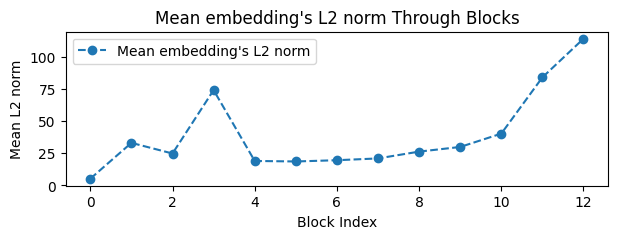

In [ ]:
EmbeddingAnalysis(llm, low_variance_text).analyze_through_blocks()
EmbeddingAnalysis(llm, high_variance_text).analyze_through_blocks()

# OLD STUFF 

In [ ]:
with llm.trace(text):
    input_embed = llm.transformer.drop.input.save()

embedding_variance = torch.var(input_embed[0], dim=1, unbiased=False)

# Calculate the mean variance across all dimensions
mean_variance = torch.mean(embedding_variance)

print(f"Embedding variance: {embedding_variance}")
print(f"Embedding variance shape: {embedding_variance.shape}")
print(f"Mean variance: {mean_variance}")

Embedding variance: tensor([0.1336, 0.0435, 0.0490, 0.0412, 0.0415, 0.0306, 0.0292, 0.0301, 0.0327,
        0.0286], device='cuda:0', grad_fn=<VarBackward0>)
Embedding variance shape: torch.Size([10])
Mean variance: 0.046016234904527664


In [ ]:
# OLD less efficient code
with llm.trace(text):

    #token_embed = llm.transformer.wte.output.save()    
    #pos_embed = llm.transformer.wpe.output.save()
    input_embed = llm.transformer.drop.input.save()


embeddings = input_embed[0].cpu().detach().numpy()
# Initialize matrices to store distances
cosine_distances = np.zeros((len(embeddings), len(embeddings)))
euclidean_distances = np.zeros((len(embeddings), len(embeddings)))

# Calculate pairwise cosine and Euclidean distances
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        if i != j:  # Skip distance calculation for the same elements
            cosine_distances[i, j] = cosine(embeddings[i], embeddings[j])
            euclidean_distances[i, j] = euclidean(embeddings[i], embeddings[j])

print("Cosine Distances:")
print(cosine_distances)

print("\nEuclidean Distances:")
print(euclidean_distances)
print(euclidean_distances.shape)

Cosine Distances:
[[0.         0.52263713 0.62112415 0.58737725 0.58948135 0.53936911
  0.54122561 0.52910638 0.60750526 0.57628381]
 [0.52263713 0.         0.36189747 0.32896525 0.40534872 0.31518441
  0.31565583 0.33754086 0.41616577 0.36109537]
 [0.62112415 0.36189747 0.         0.32251143 0.35266489 0.34703594
  0.37517387 0.40892595 0.40269136 0.40139425]
 [0.58737725 0.32896525 0.32251143 0.         0.34158105 0.27142078
  0.29008991 0.31264091 0.34585744 0.32484031]
 [0.58948135 0.40534872 0.35266489 0.34158105 0.         0.29297113
  0.30712503 0.3429631  0.28757381 0.34642351]
 [0.53936911 0.31518441 0.34703594 0.27142078 0.29297113 0.
  0.11130202 0.14600396 0.24997151 0.14352602]
 [0.54122561 0.31565583 0.37517387 0.29008991 0.30712503 0.11130202
  0.         0.09979635 0.24119663 0.09956002]
 [0.52910638 0.33754086 0.40892595 0.31264091 0.3429631  0.14600396
  0.09979635 0.         0.25449061 0.13355356]
 [0.60750526 0.41616577 0.40269136 0.34585744 0.28757381 0.24997151
  